# **COVID 19 DATA TRACKER**

# **IMPORTING LIBRARIES**

In [28]:
# importing the require libraries for the project
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import requests
import io
import os
from matplotlib.ticker import FuncFormatter

Loading COVID-19 data from online sources...
Data loaded successfully.
Processing global data...
Global data processed successfully.
Processing country-level data...
Country data processed successfully.
Global trend plot saved to covid_analysis_output/global_trend.png
Top countries plot saved to covid_analysis_output/top_countries_confirmed.png
Top countries plot saved to covid_analysis_output/top_countries_deaths.png
Top countries plot saved to covid_analysis_output/top_countries_active.png
Mortality and recovery rates plot saved to covid_analysis_output/mortality_recovery_rates.png
Daily changes plot saved to covid_analysis_output/daily_changes.png
Summary report exported to covid_analysis_output/covid19_summary_report.csv
Comprehensive analysis completed. Results saved to covid_analysis_output directory.


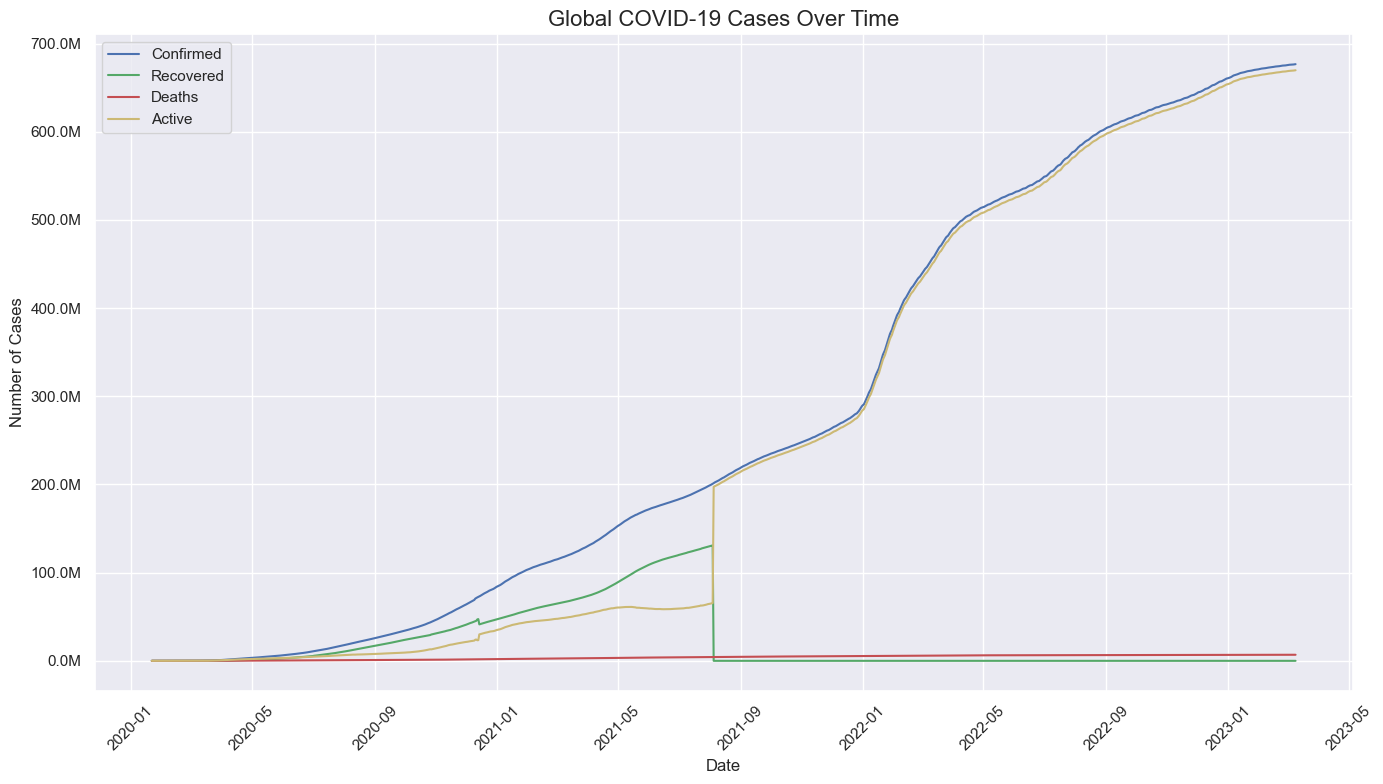

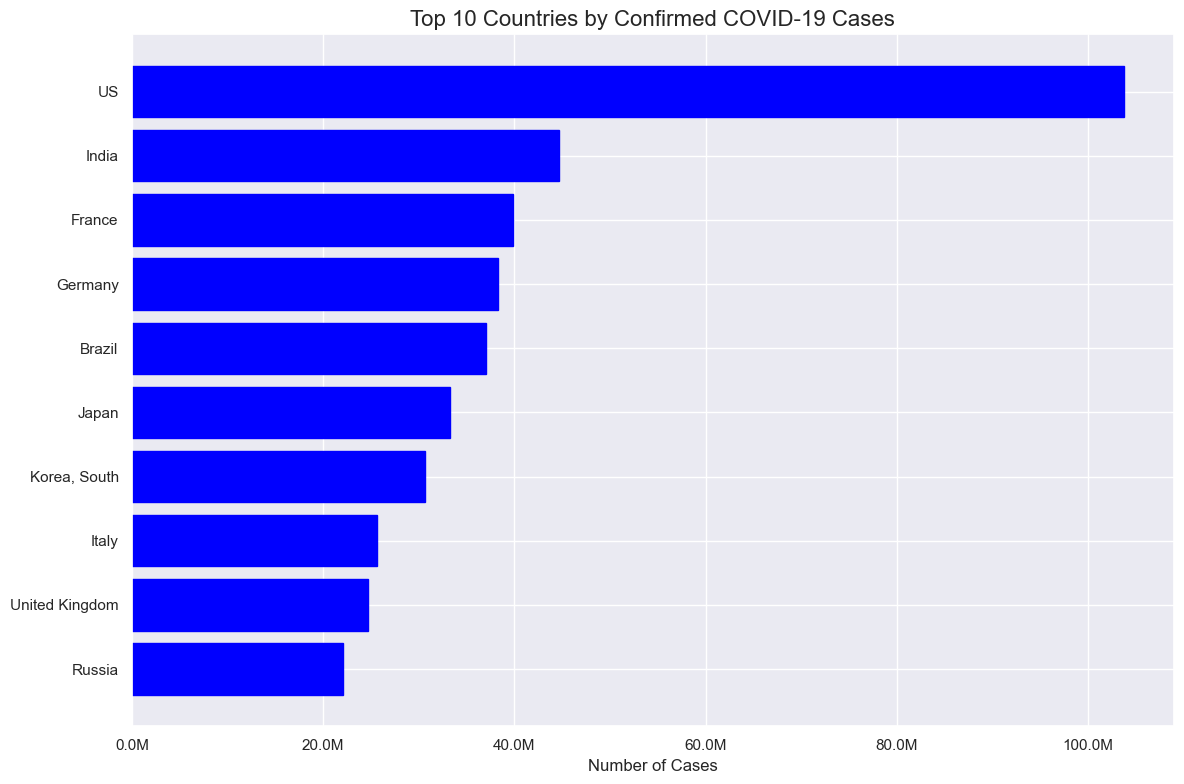

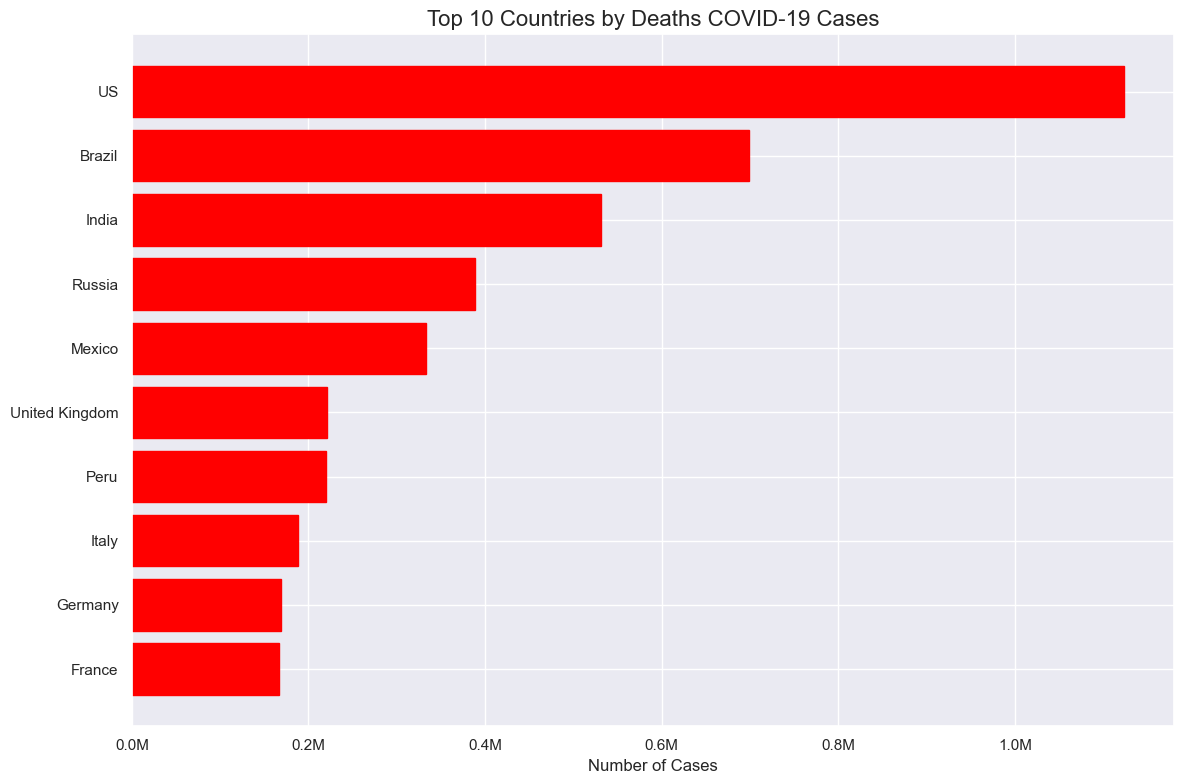

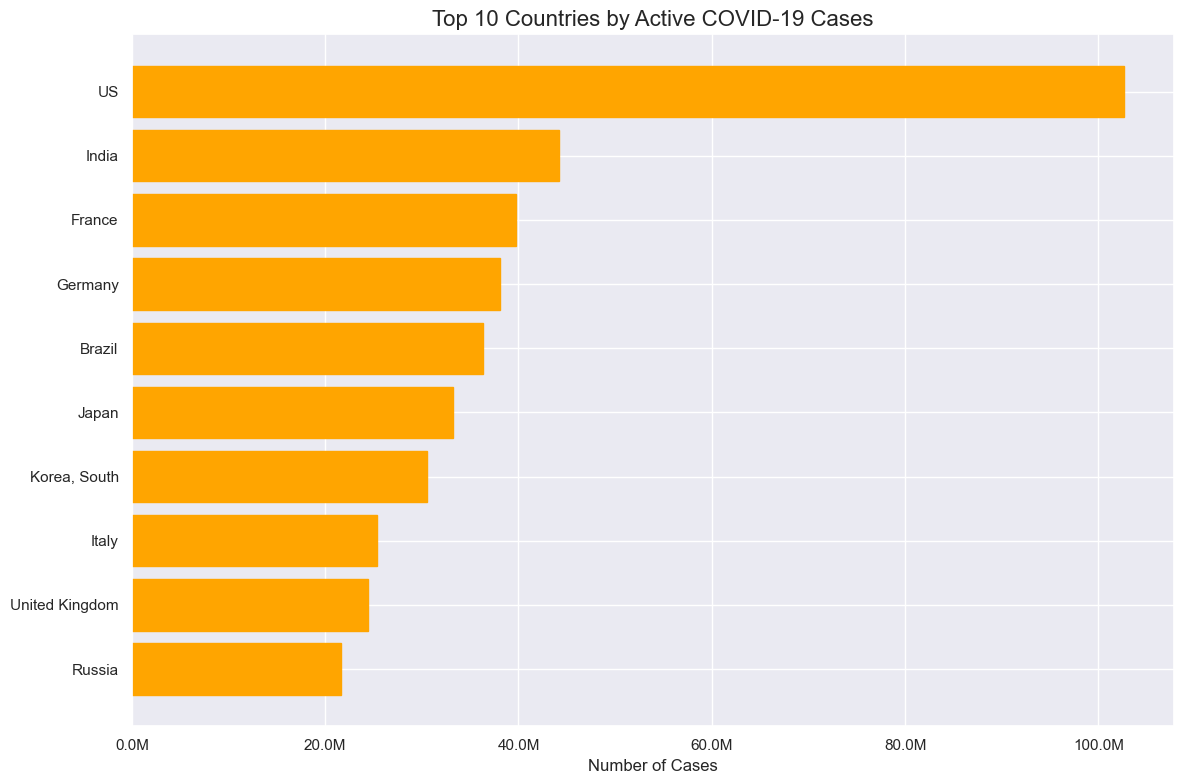

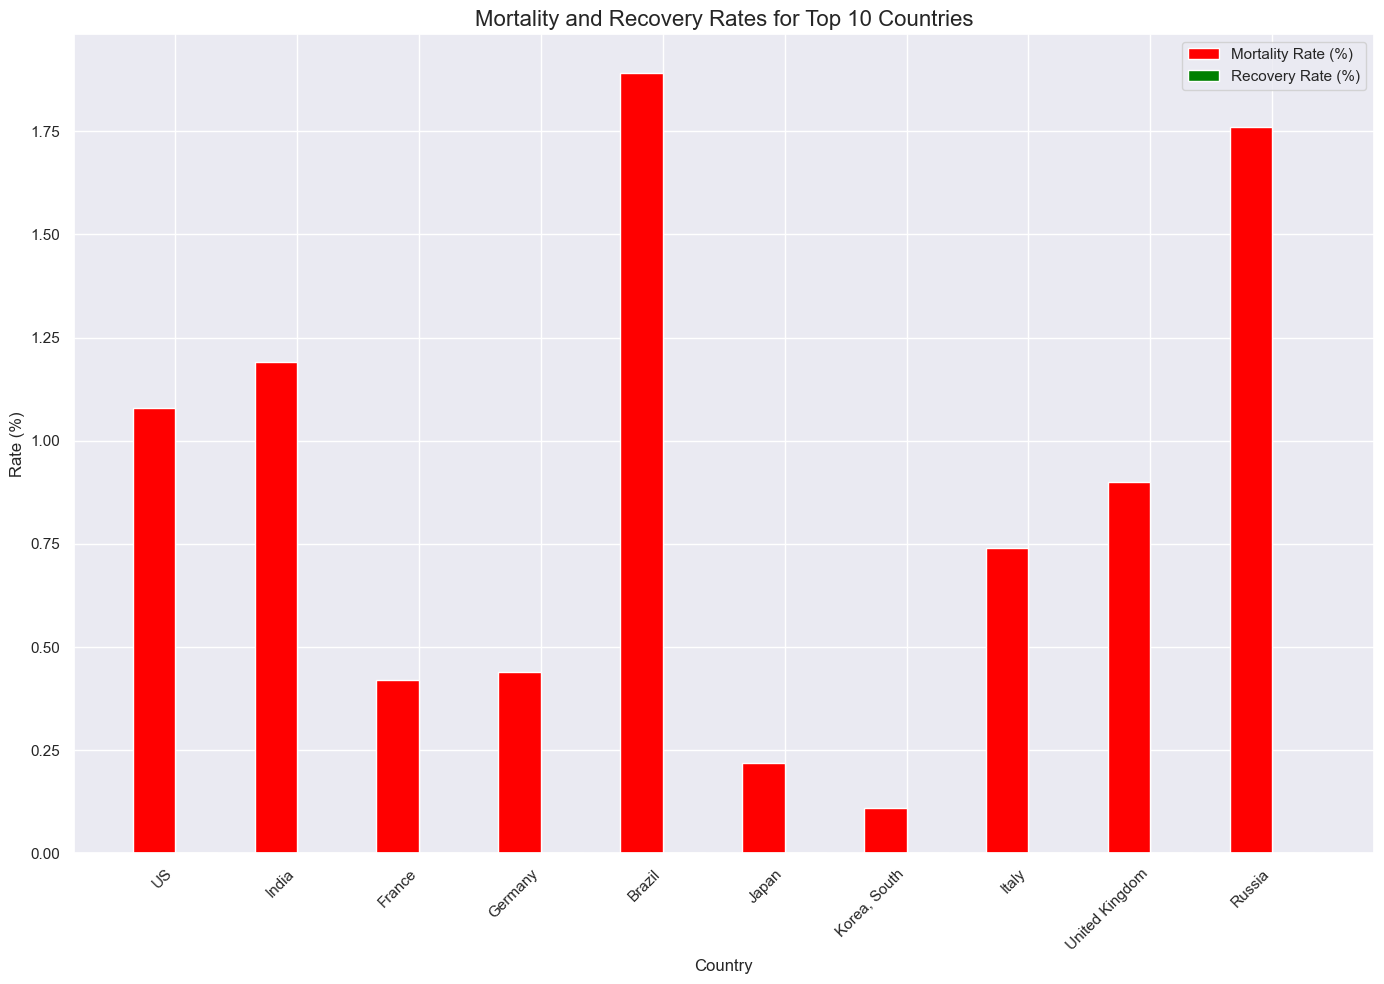

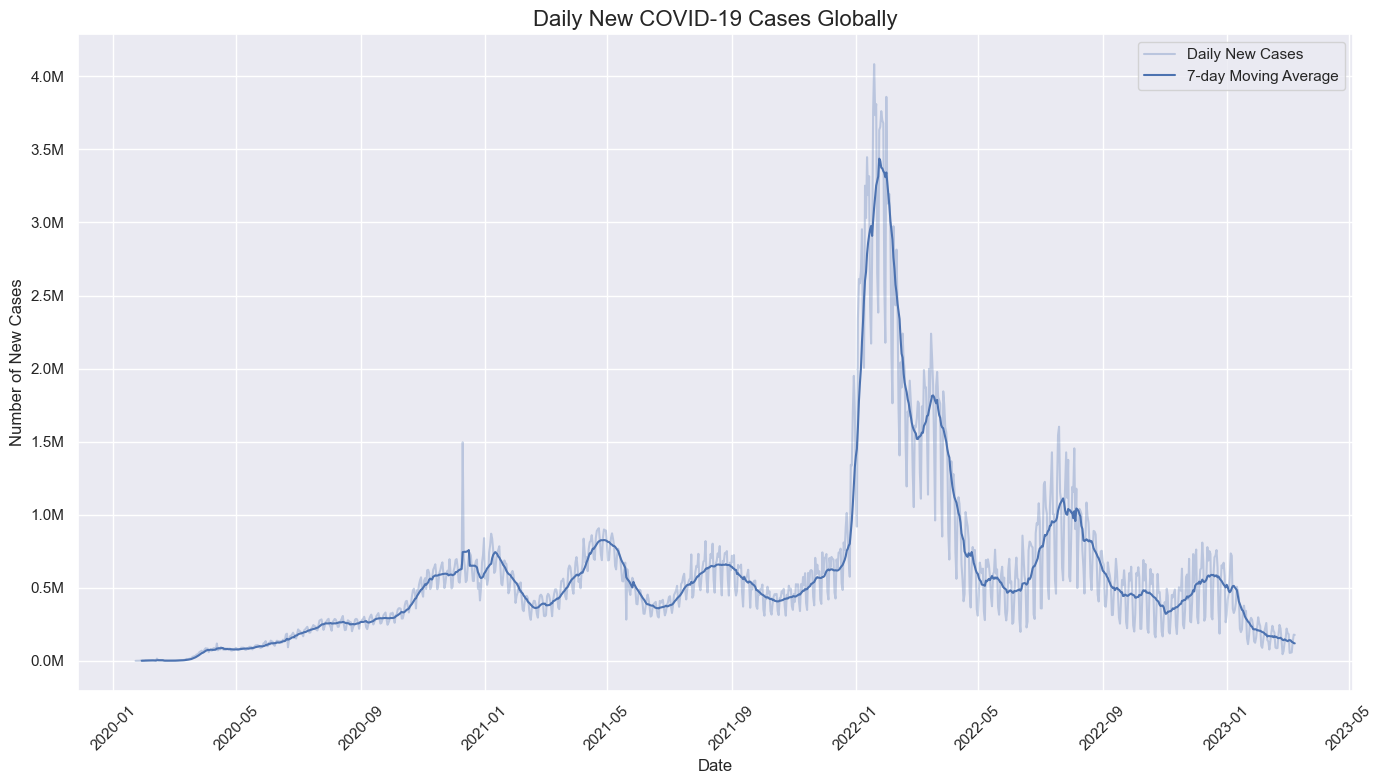

In [29]:
class CovidDataTracker:
    def __init__(self):
        """Initialize the COVID-19 Global Data Tracker"""
        # Data sources
        self.confirmed_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
        self.deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
        self.recovered_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

        # Data frames
        self.confirmed_df = None
        self.deaths_df = None
        self.recovered_df = None

        # Processed data
        self.country_data = None
        self.global_data = None

        # Setting up the visualization style
        sns.set(style="darkgrid")

    def load_data(self):
        """Load the COVID-19 data from online sources"""
        try:
            print("Loading COVID-19 data from online sources...")

            # Loading confirmed cases
            response = requests.get(self.confirmed_url)
            self.confirmed_df = pd.read_csv(io.StringIO(response.text))

            # Loading deaths
            response = requests.get(self.deaths_url)
            self.deaths_df = pd.read_csv(io.StringIO(response.text))

            # Loading the recovered cases
            response = requests.get(self.recovered_url)
            self.recovered_df = pd.read_csv(io.StringIO(response.text))

            print("Data loaded successfully.")
            return True
        except Exception as e:
            print(f"Error loading data: {e}")
            return False

    def process_global_data(self):
        """Process and prepare global data for analysis"""
        if self.confirmed_df is None or self.deaths_df is None or self.recovered_df is None:
            print("Data must be loaded first. Call load_data() method.")
            return False

        try:
            print("Processing global data...")

            # Getting the date columns (inclusive of all columns after the 4th column)
            date_columns = self.confirmed_df.columns[4:]

            # Initializing the global data dictionary
            self.global_data = {
                'dates': [datetime.strptime(date, '%m/%d/%y') for date in date_columns],
                'confirmed': [],
                'deaths': [],
                'recovered': [],
                'active': []
            }

            # Calculating global totals for each date
            for date in date_columns:
                confirmed = self.confirmed_df[date].sum()
                deaths = self.deaths_df[date].sum()
                recovered = self.recovered_df[date].sum()
                active = confirmed - deaths - recovered

                self.global_data['confirmed'].append(confirmed)
                self.global_data['deaths'].append(deaths)
                self.global_data['recovered'].append(recovered)
                self.global_data['active'].append(active)

            print("Global data processed successfully.")
            return True
        except Exception as e:
            print(f"Error processing global data: {e}")
            return False

    def process_country_data(self):
        """Process and prepare country-level data for analysis"""
        if self.confirmed_df is None or self.deaths_df is None or self.recovered_df is None:
            print("Data must be loaded first. Call load_data() method.")
            return False

        try:
            print("Processing country-level data...")

            # Geting the date columns (inclusive of all columns after the 4th column)
            date_columns = self.confirmed_df.columns[4:]
            latest_date = date_columns[-1]

            # Grouping by country and aggregate data
            country_confirmed = self.confirmed_df.groupby('Country/Region')[latest_date].sum().reset_index()
            country_deaths = self.deaths_df.groupby('Country/Region')[latest_date].sum().reset_index()
            country_recovered = self.recovered_df.groupby('Country/Region')[latest_date].sum().reset_index()

            # Merging all data into one dataframe
            self.country_data = country_confirmed.merge(country_deaths, on='Country/Region', suffixes=('_confirmed', '_deaths'))
            self.country_data = self.country_data.merge(country_recovered, on='Country/Region')

            # Renaming columns
            self.country_data.columns = ['Country', 'Confirmed', 'Deaths', 'Recovered']

            # Calculating active cases
            self.country_data['Active'] = self.country_data['Confirmed'] - self.country_data['Deaths'] - self.country_data['Recovered']

            # Calculating mortality rate
            self.country_data['Mortality Rate (%)'] = (self.country_data['Deaths'] / self.country_data['Confirmed'] * 100).round(2)

            # Calculating recovery rate
            self.country_data['Recovery Rate (%)'] = (self.country_data['Recovered'] / self.country_data['Confirmed'] * 100).round(2)

            # Sorting by confirmed cases
            self.country_data = self.country_data.sort_values(by='Confirmed', ascending=False).reset_index(drop=True)

            print("Country data processed successfully.")
            return True
        except Exception as e:
            print(f"Error processing country data: {e}")
            return False

    def plot_global_trend(self, save_path=None):
        """Plot the global trend of COVID-19 cases"""
        if self.global_data is None:
            print("Global data must be processed first. Call process_global_data() method.")
            return

        plt.figure(figsize=(14, 8))

        plt.plot(self.global_data['dates'], self.global_data['confirmed'], 'b-', label='Confirmed')
        plt.plot(self.global_data['dates'], self.global_data['recovered'], 'g-', label='Recovered')
        plt.plot(self.global_data['dates'], self.global_data['deaths'], 'r-', label='Deaths')
        plt.plot(self.global_data['dates'], self.global_data['active'], 'y-', label='Active')

        plt.title('Global COVID-19 Cases Over Time', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Number of Cases', fontsize=12)
        plt.grid(True)
        plt.legend()

        # Formating the y-axis to display numbers in millions
        def millions_formatter(x, pos):
            return f'{x/1e6:.1f}M'

        plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

        plt.xticks(rotation=45)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
            print(f"Global trend plot saved to {save_path}")
        else:
            plt.show()

    def plot_top_countries(self, metric='Confirmed', top_n=10, save_path=None):
        """Plot the top countries by the specified metric"""
        if self.country_data is None:
            print("Country data must be processed first. Call process_country_data() method.")
            return

        # Getting the top N countries by the specified metric
        top_countries = self.country_data.nlargest(top_n, metric)

        plt.figure(figsize=(12, 8))

        # Creating horizontal bar plot
        bars = plt.barh(top_countries['Country'][::-1], top_countries[metric][::-1])

        # Color mapping based on metric
        if metric == 'Confirmed':
            bar_color = 'blue'
        elif metric == 'Deaths':
            bar_color = 'red'
        elif metric == 'Recovered':
            bar_color = 'green'
        elif metric == 'Active':
            bar_color = 'orange'
        else:
            bar_color = 'purple'

        for bar in bars:
            bar.set_color(bar_color)

        plt.title(f'Top {top_n} Countries by {metric} COVID-19 Cases', fontsize=16)
        plt.xlabel('Number of Cases', fontsize=12)
        plt.tight_layout()

        # Formating x-axis to display numbers in millions or thousands
        if top_countries[metric].max() > 1000000:
            def millions_formatter(x, pos):
                return f'{x/1e6:.1f}M'
            plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))
        elif top_countries[metric].max() > 1000:
            def thousands_formatter(x, pos):
                return f'{x/1e3:.0f}K'
            plt.gca().xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

        if save_path:
            plt.savefig(save_path)
            print(f"Top countries plot saved to {save_path}")
        else:
            plt.show()

    def plot_mortality_recovery_rates(self, top_n=10, save_path=None):
        """Plot mortality and recovery rates for top affected countries"""
        if self.country_data is None:
            print("Country data must be processed first. Call process_country_data() method.")
            return

        # Getting the top N countries through confirmed cases
        top_countries = self.country_data.nlargest(top_n, 'Confirmed')

        plt.figure(figsize=(14, 10))

        # Creating a grouped bar chart
        x = np.arange(len(top_countries))
        width = 0.35

        plt.bar(x - width/2, top_countries['Mortality Rate (%)'], width, label='Mortality Rate (%)', color='red')
        plt.bar(x + width/2, top_countries['Recovery Rate (%)'], width, label='Recovery Rate (%)', color='green')

        plt.title(f'Mortality and Recovery Rates for Top {top_n} Countries', fontsize=16)
        plt.xlabel('Country', fontsize=12)
        plt.ylabel('Rate (%)', fontsize=12)
        plt.xticks(x, top_countries['Country'], rotation=45, ha='right')
        plt.grid(True, axis='y')
        plt.legend()
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
            print(f"Mortality and recovery rates plot saved to {save_path}")
        else:
            plt.show()

    def create_daily_change_analysis(self):
        """Analyze daily changes in global cases"""
        if self.global_data is None:
            print("Global data must be processed first. Call process_global_data() method.")
            return None

        try:
            # Converting the lists to numpy arrays for easier computation
            confirmed = np.array(self.global_data['confirmed'])
            deaths = np.array(self.global_data['deaths'])
            recovered = np.array(self.global_data['recovered'])

            # Calculating daily new cases
            daily_confirmed = np.diff(confirmed)
            daily_deaths = np.diff(deaths)
            daily_recovered = np.diff(recovered)

            # Calculating weekly moving average
            window_size = 7
            daily_confirmed_ma = np.convolve(daily_confirmed, np.ones(window_size)/window_size, mode='valid')
            daily_deaths_ma = np.convolve(daily_deaths, np.ones(window_size)/window_size, mode='valid')
            daily_recovered_ma = np.convolve(daily_recovered, np.ones(window_size)/window_size, mode='valid')

            # Dates for plotting (excluding first date for daily changes)
            dates = self.global_data['dates'][1:]
            ma_dates = self.global_data['dates'][window_size:]

            return {
                'dates': dates,
                'ma_dates': ma_dates,
                'daily_confirmed': daily_confirmed,
                'daily_deaths': daily_deaths,
                'daily_recovered': daily_recovered,
                'daily_confirmed_ma': daily_confirmed_ma,
                'daily_deaths_ma': daily_deaths_ma,
                'daily_recovered_ma': daily_recovered_ma
            }
        except Exception as e:
            print(f"Error calculating daily changes: {e}")
            return None

    def plot_daily_changes(self, save_path=None):
        """Plot daily changes in global cases with moving averages"""
        daily_data = self.create_daily_change_analysis()
        if daily_data is None:
            return

        plt.figure(figsize=(14, 8))

        # Ploting daily new confirmed cases and weekly moving average
        plt.plot(daily_data['dates'], daily_data['daily_confirmed'], 'b-', alpha=0.3, label='Daily New Cases')
        plt.plot(daily_data['ma_dates'], daily_data['daily_confirmed_ma'], 'b-', label='7-day Moving Average')

        plt.title('Daily New COVID-19 Cases Globally', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Number of New Cases', fontsize=12)
        plt.grid(True)
        plt.legend()

        # Formating the y-axis to display numbers in thousands or millions
        if max(daily_data['daily_confirmed']) > 1000000:
            def millions_formatter(x, pos):
                return f'{x/1e6:.1f}M'
            plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
        else:
            def thousands_formatter(x, pos):
                return f'{x/1e3:.0f}K'
            plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

        plt.xticks(rotation=45)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
            print(f"Daily changes plot saved to {save_path}")
        else:
            plt.show()

    def export_summary_report(self, filepath):
        """Export a summary report to CSV"""
        if self.country_data is None:
            print("Country data must be processed first. Call process_country_data() method.")
            return False

        try:
            # Creating a directory if it doesn't exist
            os.makedirs(os.path.dirname(filepath), exist_ok=True)

            # Exporting to CSV
            self.country_data.to_csv(filepath, index=False)
            print(f"Summary report exported to {filepath}")
            return True
        except Exception as e:
            print(f"Error exporting summary report: {e}")
            return False

    def calculate_statistics(self):
        """Calculate important statistics about the pandemic"""
        if self.global_data is None or self.country_data is None:
            print("Both global and country data must be processed first.")
            return None

        try:
            stats = {}

            # Fetching the latest data
            latest_global_confirmed = self.global_data['confirmed'][-1]
            latest_global_deaths = self.global_data['deaths'][-1]
            latest_global_recovered = self.global_data['recovered'][-1]
            latest_global_active = self.global_data['active'][-1]

            # Calculating the global statistics
            stats['total_cases'] = latest_global_confirmed
            stats['total_deaths'] = latest_global_deaths
            stats['total_recovered'] = latest_global_recovered
            stats['active_cases'] = latest_global_active
            stats['global_mortality_rate'] = (latest_global_deaths / latest_global_confirmed * 100).round(2)
            stats['global_recovery_rate'] = (latest_global_recovered / latest_global_confirmed * 100).round(2)

            # Calculating a country-specific statistics
            stats['most_affected_country'] = self.country_data.iloc[0]['Country']
            stats['highest_cases_country'] = self.country_data.iloc[0]['Confirmed']
            stats['highest_deaths_country'] = self.country_data.sort_values(by='Deaths', ascending=False).iloc[0]['Country']
            stats['highest_mortality_country'] = self.country_data.sort_values(by='Mortality Rate (%)', ascending=False).iloc[0]['Country']
            stats['highest_mortality_rate'] = self.country_data.sort_values(by='Mortality Rate (%)', ascending=False).iloc[0]['Mortality Rate (%)']

            return stats
        except Exception as e:
            print(f"Error calculating statistics: {e}")
            return None

    def run_comprehensive_analysis(self, output_dir="covid_analysis_output"):
        """Run a comprehensive analysis and save all outputs"""
        # Creating output directory
        os.makedirs(output_dir, exist_ok=True)

        # Loading and processing the data
        if not self.load_data():
            return False

        if not self.process_global_data():
            return False

        if not self.process_country_data():
            return False

        # Generating plots and also saving them
        self.plot_global_trend(save_path=f"{output_dir}/global_trend.png")
        self.plot_top_countries(metric='Confirmed', save_path=f"{output_dir}/top_countries_confirmed.png")
        self.plot_top_countries(metric='Deaths', save_path=f"{output_dir}/top_countries_deaths.png")
        self.plot_top_countries(metric='Active', save_path=f"{output_dir}/top_countries_active.png")
        self.plot_mortality_recovery_rates(save_path=f"{output_dir}/mortality_recovery_rates.png")
        self.plot_daily_changes(save_path=f"{output_dir}/daily_changes.png")

        # Exporting summary report
        self.export_summary_report(f"{output_dir}/covid19_summary_report.csv")

        # Calculating statistics
        stats = self.calculate_statistics()
        if stats:
            with open(f"{output_dir}/covid19_statistics.txt", "w") as f:
                f.write("COVID-19 Global Statistics Summary\n")
                f.write("================================\n\n")
                f.write(f"Total Confirmed Cases: {stats['total_cases']:,}\n")
                f.write(f"Total Deaths: {stats['total_deaths']:,}\n")
                f.write(f"Total Recovered: {stats['total_recovered']:,}\n")
                f.write(f"Active Cases: {stats['active_cases']:,}\n\n")
                f.write(f"Global Mortality Rate: {stats['global_mortality_rate']}%\n")
                f.write(f"Global Recovery Rate: {stats['global_recovery_rate']}%\n\n")
                f.write(f"Most Affected Country: {stats['most_affected_country']} ({stats['highest_cases_country']:,} cases)\n")
                f.write(f"Country with Highest Deaths: {stats['highest_deaths_country']}\n")
                f.write(f"Country with Highest Mortality Rate: {stats['highest_mortality_country']} ({stats['highest_mortality_rate']}%)\n")

        print(f"Comprehensive analysis completed. Results saved to {output_dir} directory.")
        return True

if __name__ == "__main__":
    tracker = CovidDataTracker()
    tracker.run_comprehensive_analysis()

COVID-19 Global Data Tracker Demo

Step 1: Loading COVID-19 data...
Loading COVID-19 data from online sources...
Data loaded successfully.

Step 2: Processing global data...
Processing global data...
Global data processed successfully.

Step 3: Processing country-level data...
Processing country-level data...
Country data processed successfully.

Step 4: Visualizing global trends...
Global trend plot saved to covid_analysis_results/global_trend.png

Step 5: Visualizing top countries by confirmed cases...
Top countries plot saved to covid_analysis_results/top_countries_confirmed.png

Step 6: Visualizing top countries by deaths...
Top countries plot saved to covid_analysis_results/top_countries_deaths.png

Step 7: Visualizing mortality and recovery rates...
Mortality and recovery rates plot saved to covid_analysis_results/mortality_recovery_rates.png

Step 8: Visualizing daily changes in global cases...
Daily changes plot saved to covid_analysis_results/daily_changes.png

Step 9: Exporti

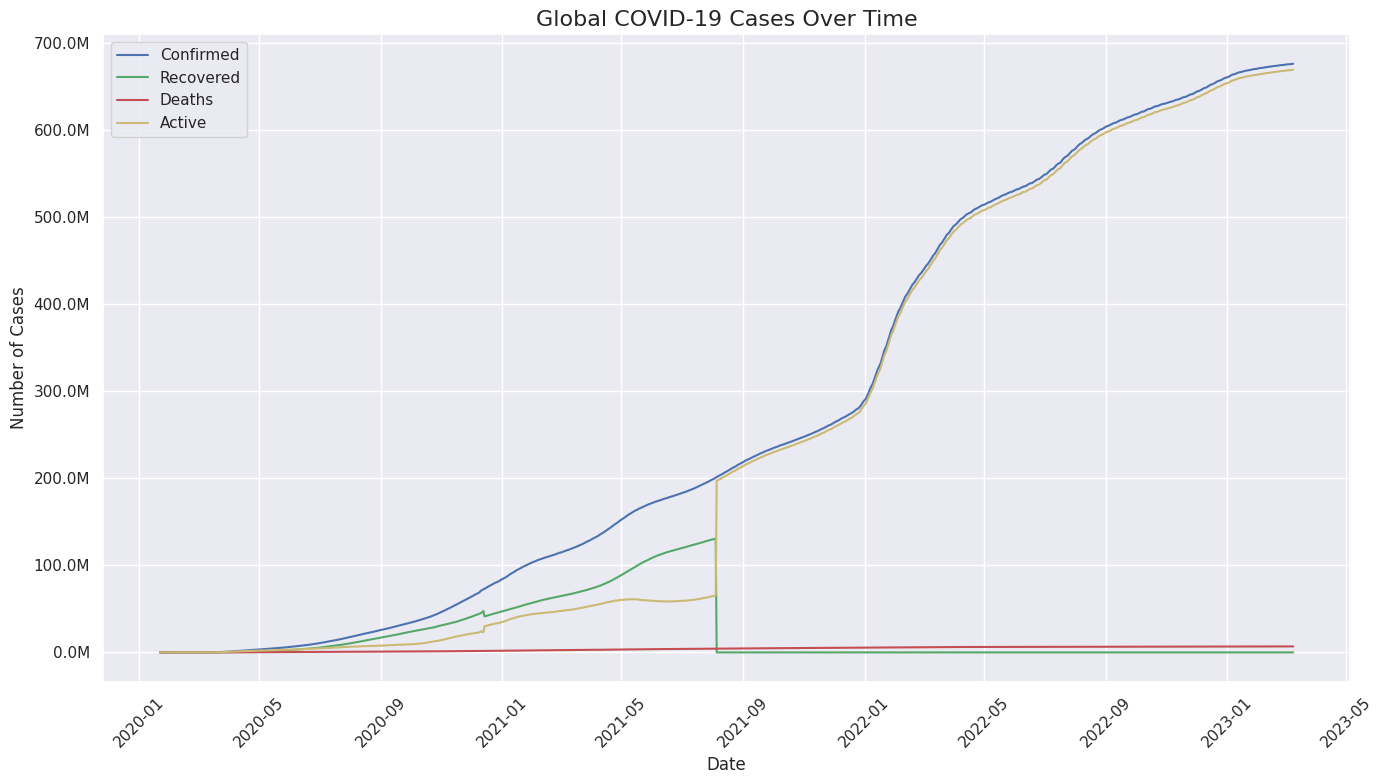

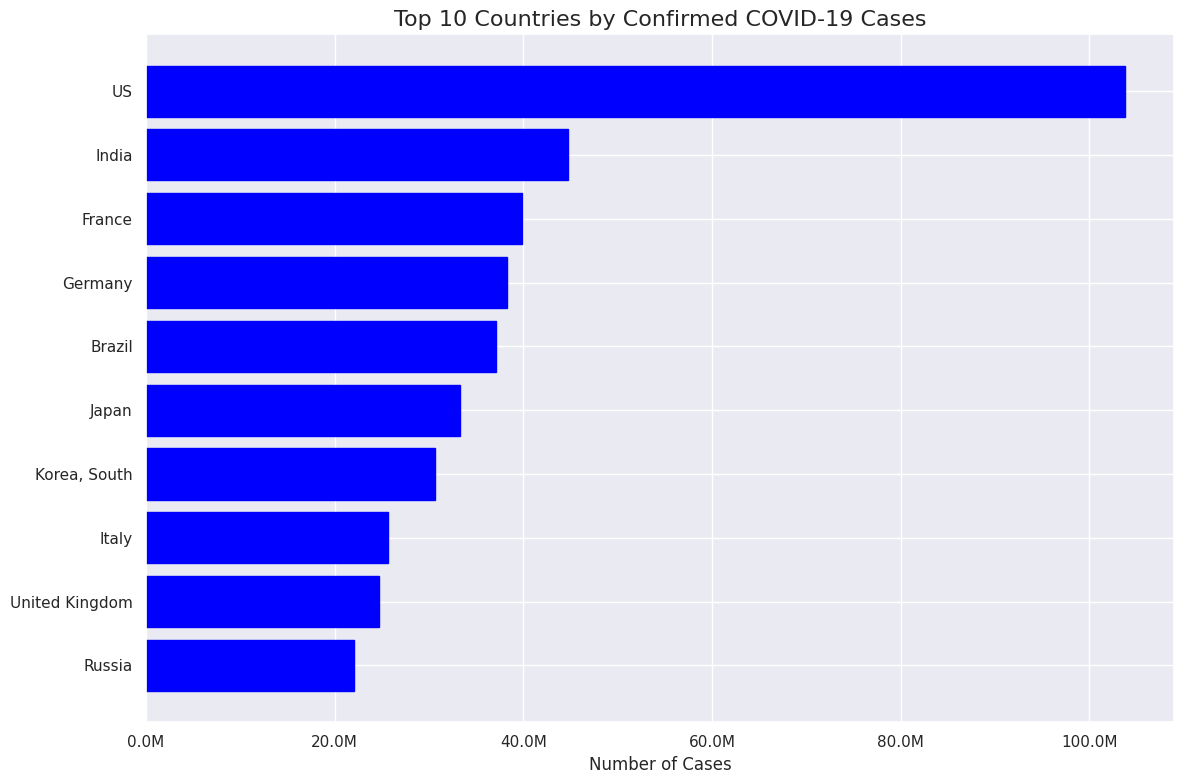

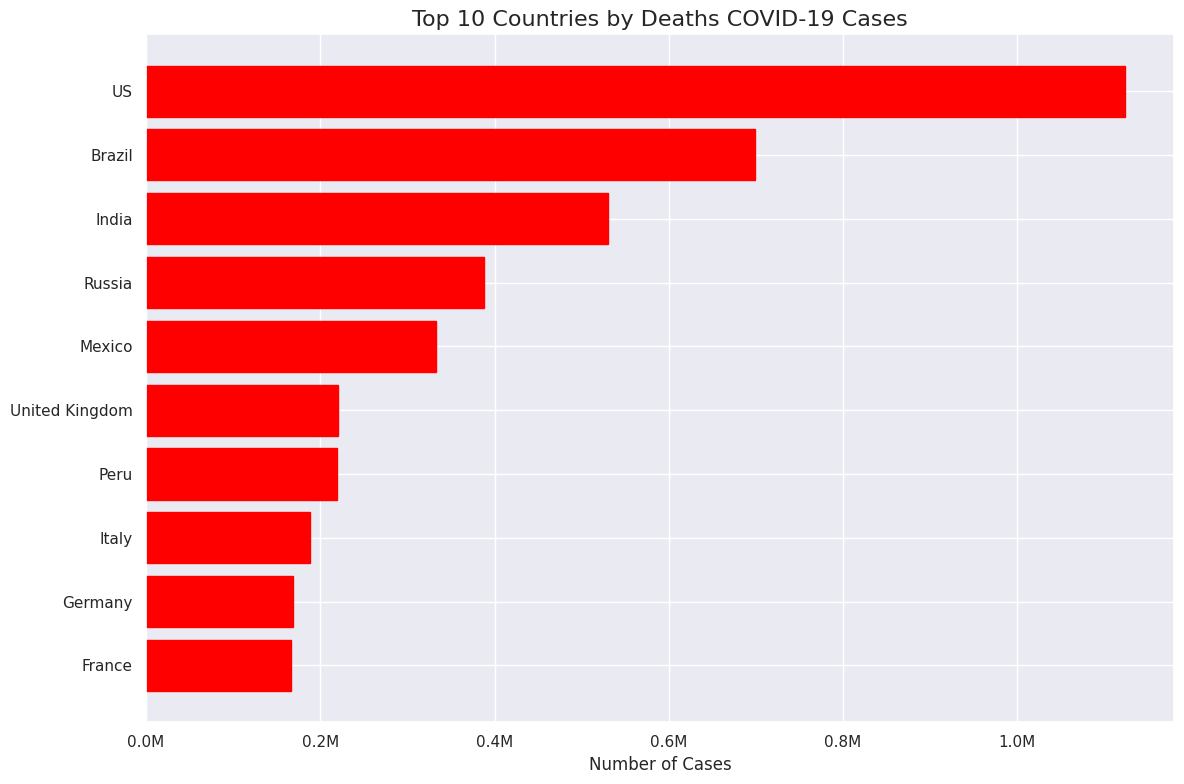

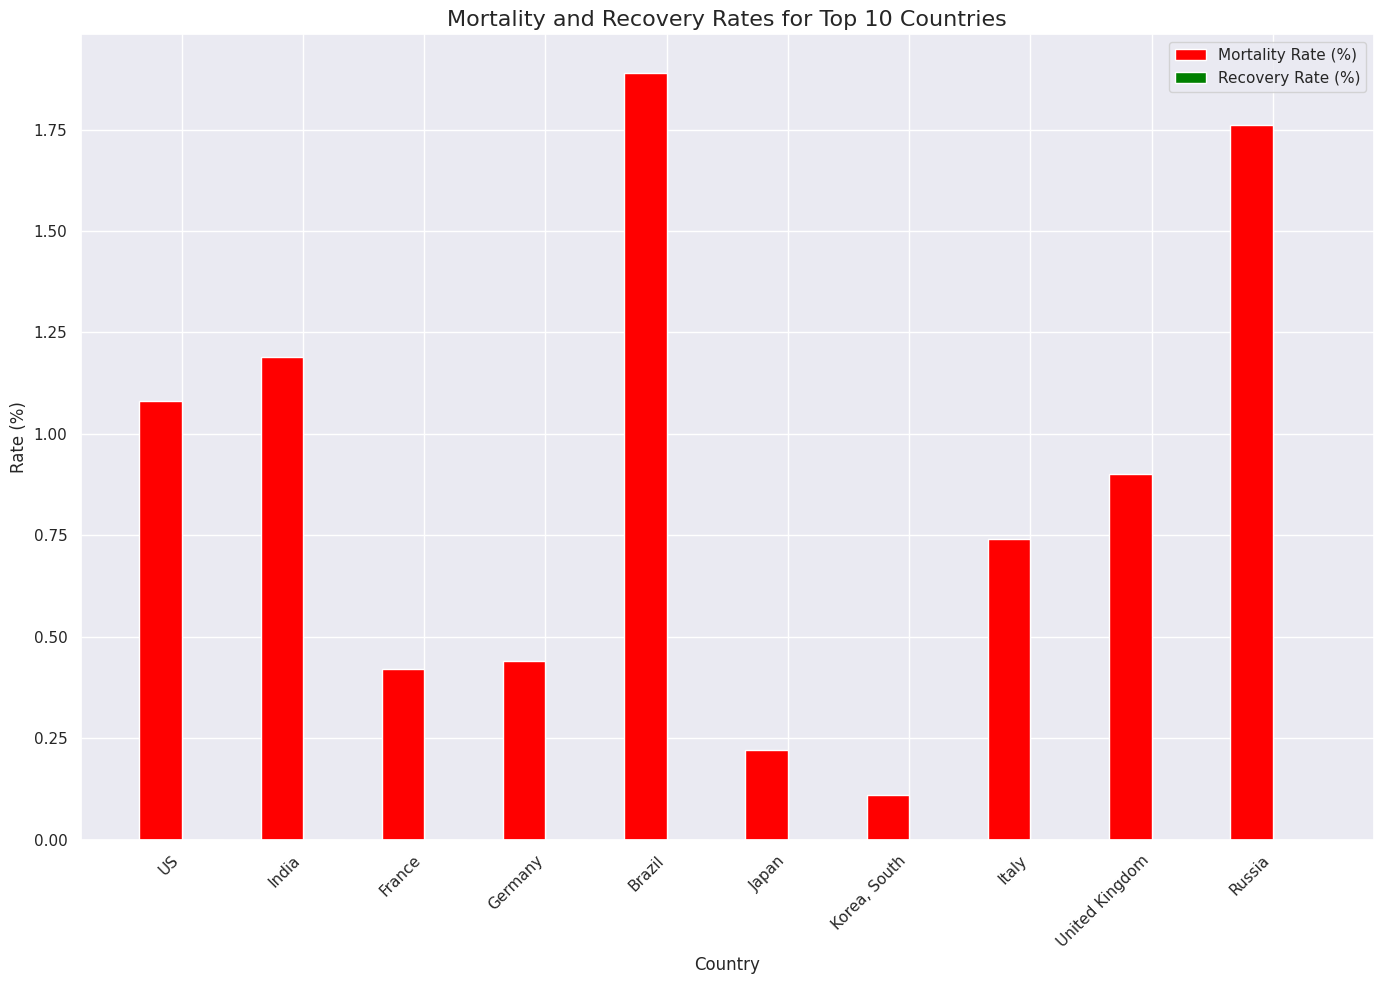

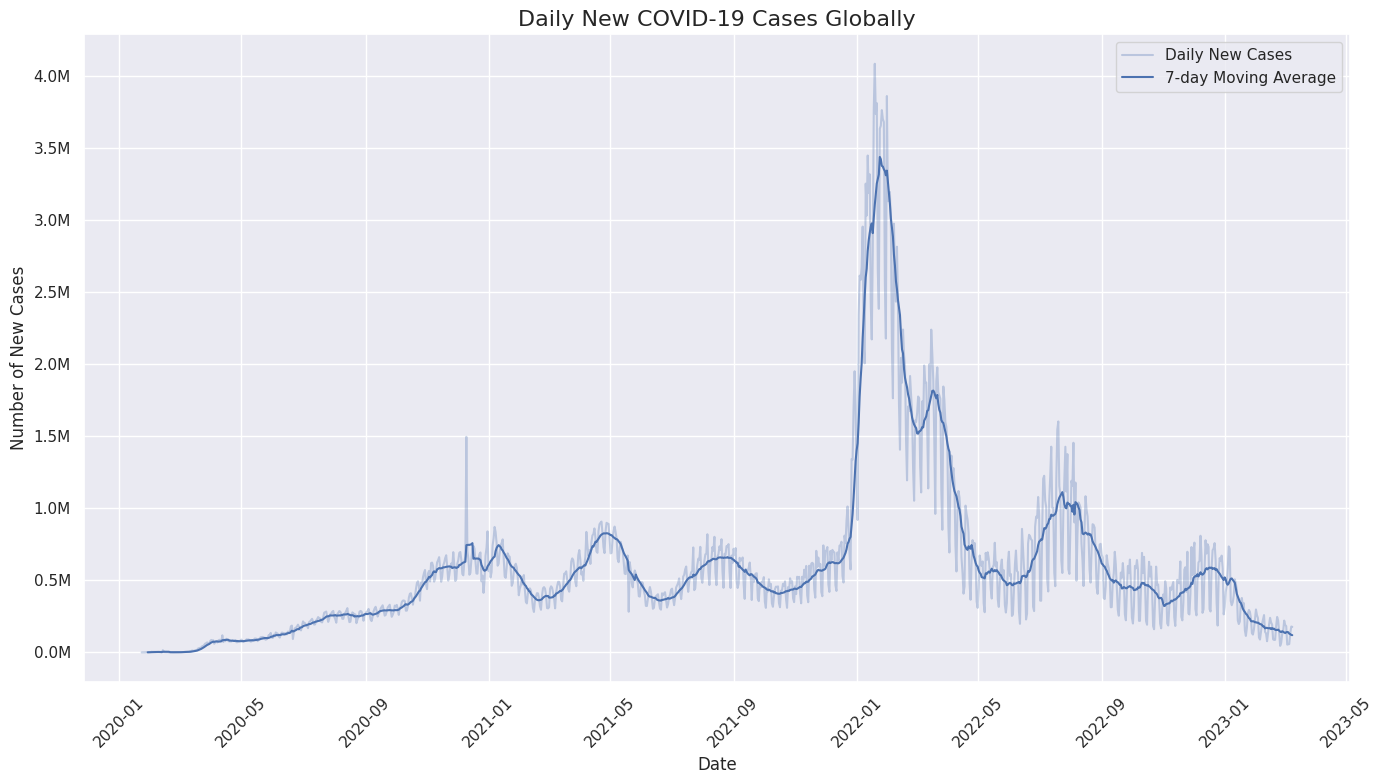

In [11]:
# DATA TRACKER DEMO
def main():
    print("=" * 50)
    print("COVID-19 Global Data Tracker Demo")
    print("=" * 50)

    # Creating an instance of the tracker
    tracker = CovidDataTracker()

    # Loading the data
    print("\nStep 1: Loading COVID-19 data...")
    if not tracker.load_data():
        print("Failed to load data. Exiting.")
        return

    # Processing global data
    print("\nStep 2: Processing global data...")
    if not tracker.process_global_data():
        print("Failed to process global data. Exiting.")
        return

    # Processing country data
    print("\nStep 3: Processing country-level data...")
    if not tracker.process_country_data():
        print("Failed to process country data. Exiting.")
        return

    # Creating output directory for visualizations
    output_dir = "covid_analysis_results"
    os.makedirs(output_dir, exist_ok=True)

    # Visualizing the global trends
    print("\nStep 4: Visualizing global trends...")
    tracker.plot_global_trend(save_path=f"{output_dir}/global_trend.png")

    # Visualizing the top countries by confirmed cases
    print("\nStep 5: Visualizing top countries by confirmed cases...")
    tracker.plot_top_countries(metric='Confirmed', top_n=10, save_path=f"{output_dir}/top_countries_confirmed.png")

    # Visualizing the top countries by deaths
    print("\nStep 6: Visualizing top countries by deaths...")
    tracker.plot_top_countries(metric='Deaths', top_n=10, save_path=f"{output_dir}/top_countries_deaths.png")

    # Visualizing the mortality and recovery rates
    print("\nStep 7: Visualizing mortality and recovery rates...")
    tracker.plot_mortality_recovery_rates(top_n=10, save_path=f"{output_dir}/mortality_recovery_rates.png")

    # Visualizing the daily changes
    print("\nStep 8: Visualizing daily changes in global cases...")
    tracker.plot_daily_changes(save_path=f"{output_dir}/daily_changes.png")

    # Exporting the summary report
    print("\nStep 9: Exporting summary report...")
    tracker.export_summary_report(f"{output_dir}/covid19_summary_report.csv")

    # Calculateing the statistics
    print("\nStep 10: Calculating global statistics...")
    stats = tracker.calculate_statistics()

    if stats:
        print("\nCOVID-19 Global Statistics Summary:")
        print(f"Total Confirmed Cases: {stats['total_cases']:,}")
        print(f"Total Deaths: {stats['total_deaths']:,}")
        print(f"Total Recovered: {stats['total_recovered']:,}")
        print(f"Active Cases: {stats['active_cases']:,}")
        print(f"Global Mortality Rate: {stats['global_mortality_rate']}%")
        print(f"Global Recovery Rate: {stats['global_recovery_rate']}%")
        print(f"Most Affected Country: {stats['most_affected_country']} ({stats['highest_cases_country']:,} cases)")
        print(f"Country with Highest Mortality Rate: {stats['highest_mortality_country']} ({stats['highest_mortality_rate']}%)")

    print(f"\nAnalysis complete! All results saved to the '{output_dir}' directory.")
    print("\nYou can now explore the visualization files and the CSV report.")

if __name__ == "__main__":
    main()
